<a href="https://colab.research.google.com/github/Dare-Badejo-001/Optimization-Problems/blob/main/Machine_scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null

solver = "appsi_highs"

import pyomo.environ as pyo

SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
# Job Data

In [4]:
jobs = pd.DataFrame(
    {
        "A": {"release": 2, "duration": 5, "due": 10},
        "B": {"release": 5, "duration": 6, "due": 21},
        "C": {"release": 4, "duration": 8, "due": 15},
        "D": {"release": 0, "duration": 4, "due": 10},
        "E": {"release": 0, "duration": 2, "due": 5},
        "F": {"release": 8, "duration": 3, "due": 15},
        "G": {"release": 9, "duration": 2, "due": 22},
    }
).T
display(jobs)

,release,duration,due
A,2,5,10
B,5,6,21
C,4,8,15
D,0,4,10
E,0,2,5
F,8,3,15
G,9,2,22


In [ ]:
#Schedule Data


In [5]:
def schedule_jobs(jobs, seq):
    schedule = pd.DataFrame(index=jobs.index)
    t = 0
    for job in seq:
        t = max(t, jobs.loc[job]["release"])
        schedule.loc[job, "start"] = t
        t += jobs.loc[job, "duration"]
        schedule.loc[job, "finish"] = t
        schedule.loc[job, "past"] = max(0, t - jobs.loc[job, "due"])

    return schedule


schedule = schedule_jobs(jobs, jobs.index)
schedule

,start,finish,past
A,2.0,7.0,0.0
B,7.0,13.0,0.0
C,13.0,21.0,6.0
D,21.0,25.0,15.0
E,25.0,27.0,22.0
F,27.0,30.0,15.0
G,30.0,32.0,10.0


In [ ]:
# Gantt Chart

Using the "job order" strategy, the total past due is 68.0


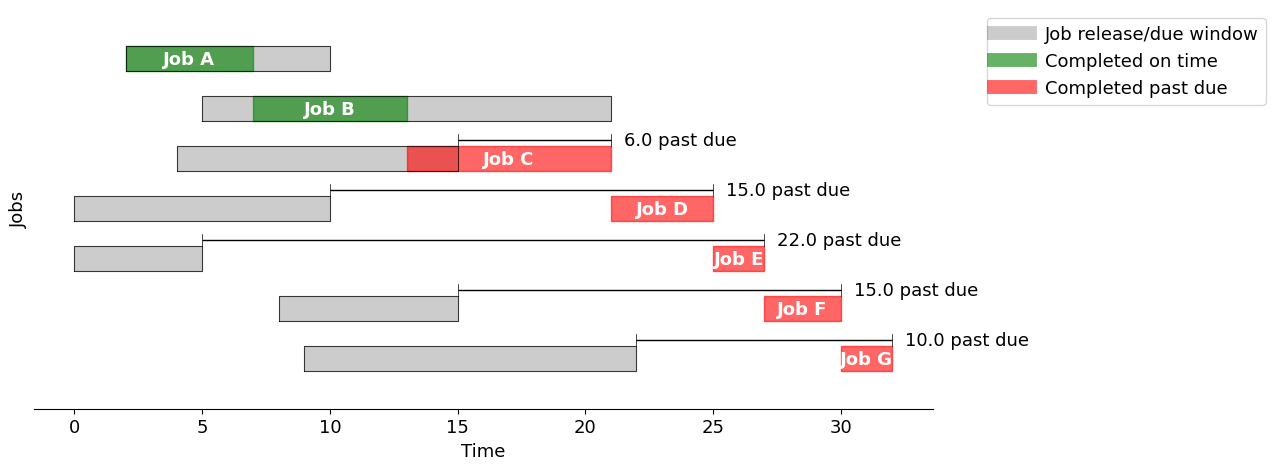

In [6]:
def gantt(jobs, schedule, title=""):
    w = 0.25  # bar width

    plt.rcParams.update({"font.size": 13})
    fig, ax = plt.subplots(1, 1, figsize=(13, 0.7 * len(jobs.index)))

    for k, job in enumerate(jobs.index):
        r = jobs.loc[job, "release"]
        d = jobs.loc[job, "due"]
        s = schedule.loc[job, "start"]
        f = schedule.loc[job, "finish"]

        # Show job release-due window
        ax.fill_between(
            [r, d], [-k - w, -k - w], [-k + w, -k + w], lw=1, color="k", alpha=0.2
        )
        ax.plot(
            [r, r, d, d, r], [-k - w, -k + w, -k + w, -k - w, -k - w], lw=0.5, color="k"
        )

        # Show job start-finish window
        color = "g" if f <= d else "r"
        ax.fill_between(
            [s, f], [-k - w, -k - w], [-k + w, -k + w], color=color, alpha=0.6
        )
        ax.text(
            (s + f) / 2.0,
            -k,
            "Job " + job,
            color="white",
            weight="bold",
            ha="center",
            va="center",
        )

        # If past due
        if f > d:
            ax.plot([d] * 2, [-k + w, -k + 2 * w], lw=0.5, color="k")
            ax.plot([f] * 2, [-k + w, -k + 2 * w], lw=0.5, color="k")
            ax.plot([d, f], [-k + 1.5 * w] * 2, solid_capstyle="butt", lw=1, color="k")
            ax.text(
                f + 0.5,
                -k + 1.5 * w,
                f"{schedule.loc[job, 'past']} past due",
                va="center",
            )

    total_past_due = schedule["past"].sum()
    ax.set_ylim(-len(jobs.index), 1)
    print(f'Using the "{title}" strategy, the total past due is {total_past_due}')
    ax.set_xlabel("Time")
    ax.set_ylabel("Jobs")
    ax.set_yticks([])
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    custom_lines = [
        Line2D([0], [0], c="k", lw=10, alpha=0.2),
        Line2D([0], [0], c="g", lw=10, alpha=0.6),
        Line2D([0], [0], c="r", lw=10, alpha=0.6),
    ]
    ax.legend(
        custom_lines,
        ["Job release/due window", "Completed on time", "Completed past due"],
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    plt.tight_layout()
    plt.show()


gantt(jobs, schedule, "job order")

In [ ]:
# Empirical Scheduling Rules

Using the "First in, First out" strategy, the total past due is 31.0


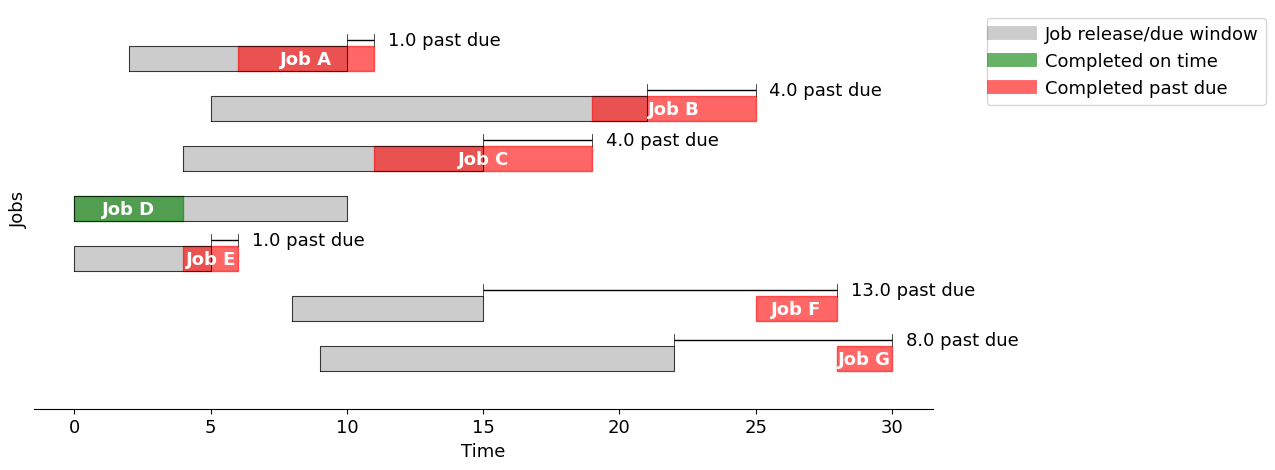

In [7]:
fifo = schedule_jobs(jobs, jobs.sort_values(by="release").index)
gantt(jobs, fifo, "First in, First out")

In [ ]:
# EDD

Using the "Earliest due date" strategy, the total past due is 27.0


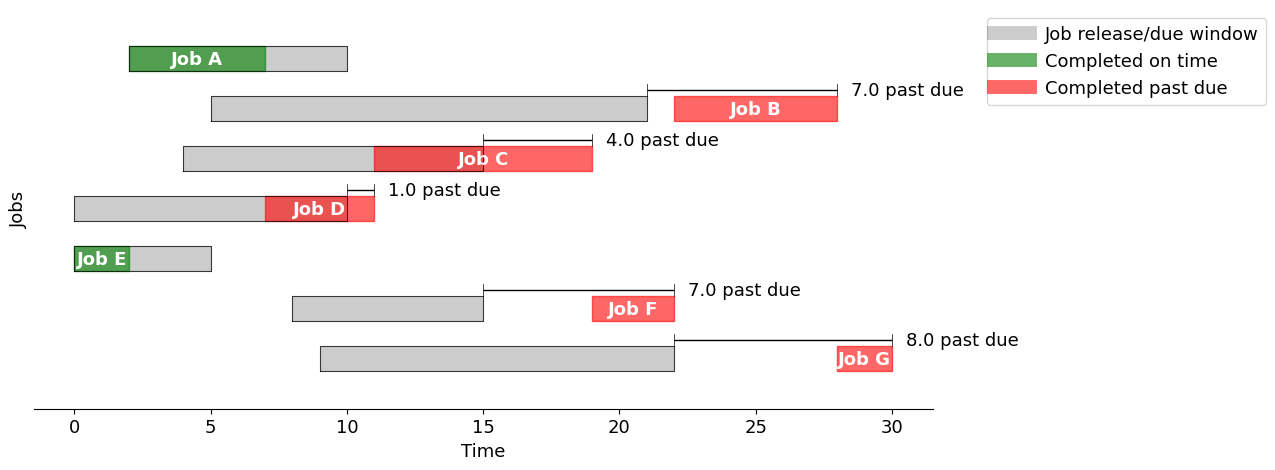

In [8]:
edd = schedule_jobs(jobs, jobs.sort_values(by="due").index)
gantt(jobs, edd, "Earliest due date")

Using the "Shortest Processing Time" strategy, the total past due is 51.0


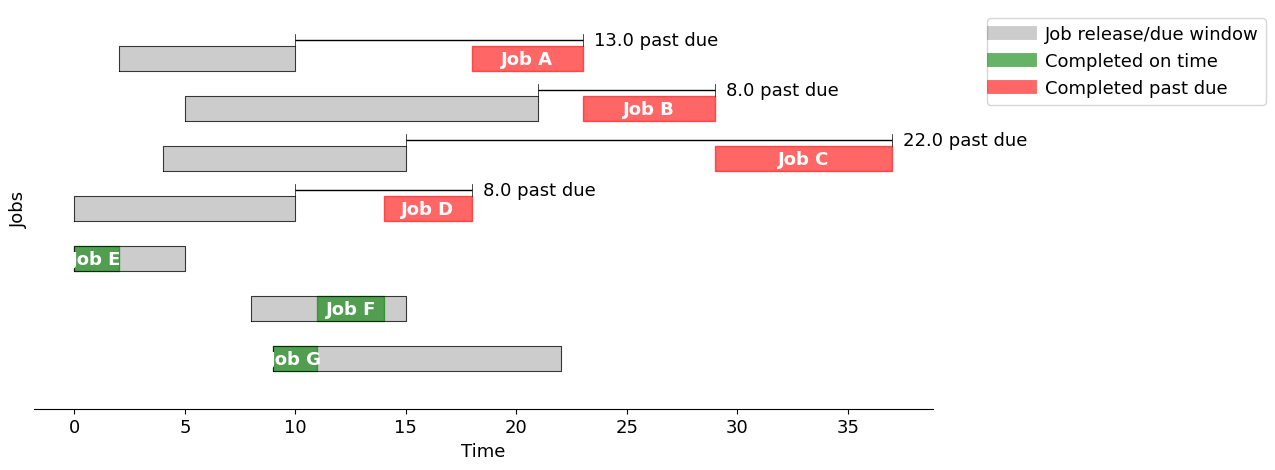

In [9]:
# Shortest processing time (SPT)
spt = schedule_jobs(jobs, jobs.sort_values(by="duration").index)
gantt(jobs, spt, "Shortest Processing Time")

In [ ]:
# Optimal scheduling using disjunctive programming

,start,finish,past
A,6.000000e+00,11.0,1.0
B,1.400000e+01,20.0,-0.0
C,2.200000e+01,30.0,15.0
D,2.000000e+00,6.0,-0.0
E,-5.329071e-15,2.0,-0.0
F,1.100000e+01,14.0,0.0
G,2.000000e+01,22.0,0.0


Using the "Minimize total past due" strategy, the total past due is 15.999999999999996


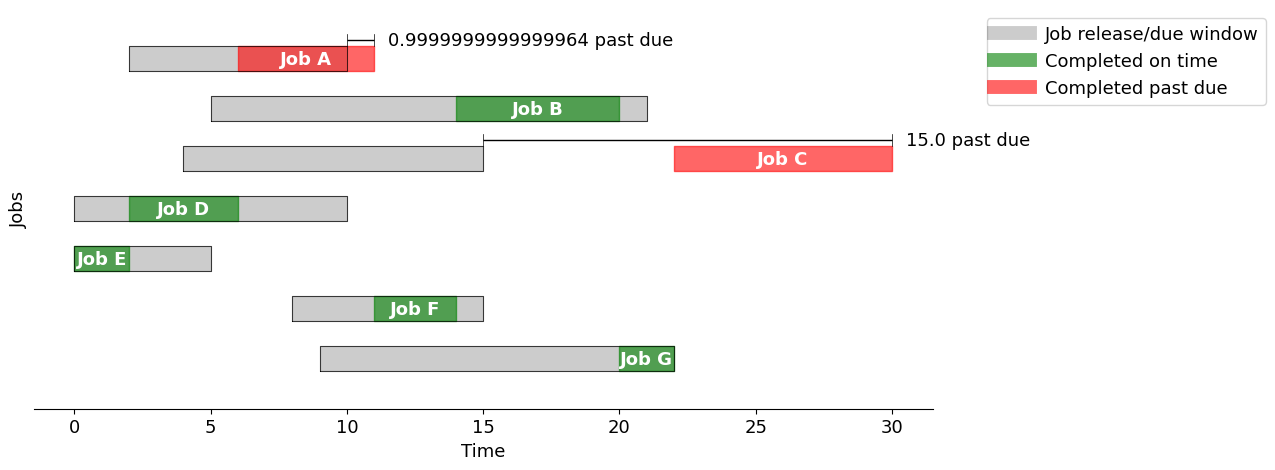

In [10]:
def machine_schedule(jobs):
    m = pyo.ConcreteModel("Job machine scheduling")

    # Create a set of jobs using the dataframe index and a
    # set of orderd pairs of distinct jobs (i,j) with i < j
    m.JOBS = pyo.Set(initialize=jobs.index)
    m.PAIRS = pyo.Set(initialize=m.JOBS * m.JOBS, filter=lambda m, i, j: i < j)

    # We set an upper bound on the time horizon to 100
    m.maxtime = pyo.Param(initialize=100)
    m.start = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))
    m.finish = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))
    m.past = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))

    @m.Constraint(m.JOBS)
    def job_release(m, job):
        return m.start[job] >= jobs.loc[job, "release"]

    @m.Constraint(m.JOBS)
    def job_duration(m, job):
        return m.finish[job] == m.start[job] + jobs.loc[job, "duration"]

    @m.Constraint(m.JOBS)
    def past_due_constraint(m, job):
        return m.past[job] >= m.finish[job] - jobs.loc[job, "due"]

    @m.Disjunction(m.PAIRS, xor=True)
    def machine_deconflict(m, job_a, job_b):
        return [m.finish[job_a] <= m.start[job_b], m.finish[job_b] <= m.start[job_a]]

    @m.Objective(sense=pyo.minimize)
    def minimize_past(m):
        return sum(m.past[job] for job in m.JOBS)

    return m


m = machine_schedule(jobs)
pyo.TransformationFactory("gdp.bigm").apply_to(m)
SOLVER.solve(m)

optimalschedule = pd.DataFrame(
    {
        "start": m.start.extract_values(),
        "finish": m.finish.extract_values(),
        "past": m.past.extract_values(),
    }
)

display(optimalschedule)
gantt(jobs, optimalschedule, "Minimize total past due")

,start,finish,past
A,2.0,7.0,-0.0
B,14.0,20.0,0.0
C,22.0,30.0,15.0
D,7.0,11.0,1.0
E,0.0,2.0,-0.0
F,11.0,14.0,-0.0
G,20.0,22.0,0.0


Using the "Minimize total past due" strategy, the total past due is 15.99999999999999


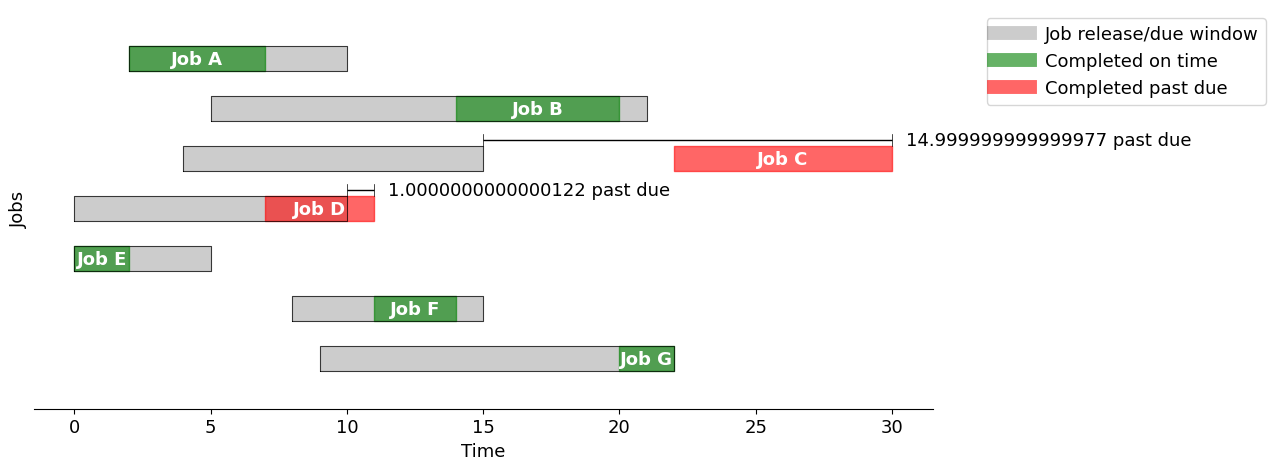

In [11]:
def machine_scheduleMILO(jobs):
    m = pyo.ConcreteModel("Job machine scheduling using MILO formulation")

    m.JOBS = pyo.Set(initialize=jobs.index)
    m.PAIRS = pyo.Set(initialize=m.JOBS * m.JOBS, filter=lambda m, i, j: i < j)

    m.maxtime = pyo.Param(initialize=100)
    m.start = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))
    m.finish = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))
    m.past = pyo.Var(m.JOBS, domain=pyo.NonNegativeReals, bounds=(0, m.maxtime))

    # Auxiliary binary variables to linearize the disjunction using the big-M approach
    m.z = pyo.Var(m.PAIRS, domain=pyo.Binary)
    m.bigM = pyo.Param(initialize=10000)

    @m.Constraint(m.JOBS)
    def job_release(m, job):
        return m.start[job] >= jobs.loc[job, "release"]

    @m.Constraint(m.JOBS)
    def job_duration(m, job):
        return m.finish[job] == m.start[job] + jobs.loc[job, "duration"]

    @m.Constraint(m.JOBS)
    def past_due_constraint(m, job):
        return m.past[job] >= m.finish[job] - jobs.loc[job, "due"]

    @m.Constraint(m.PAIRS)
    def machine_deconflict_a(m, job_a, job_b):
        return m.finish[job_a] <= m.start[job_b] + m.bigM * (1 - m.z[job_a, job_b])

    @m.Constraint(m.PAIRS)
    def machine_deconflict_b(m, job_a, job_b):
        return m.finish[job_b] <= m.start[job_a] + m.bigM * m.z[job_a, job_b]

    @m.Objective(sense=pyo.minimize)
    def minimize_past(m):
        return sum(m.past[job] for job in m.JOBS)

    SOLVER.solve(m)

    return m


m = machine_scheduleMILO(jobs)

optimalschedule_MILO = pd.DataFrame(
    {
        "start": m.start.extract_values(),
        "finish": m.finish.extract_values(),
        "past": m.past.extract_values(),
    }
)

display(optimalschedule_MILO)
gantt(jobs, optimalschedule_MILO, "Minimize total past due")